In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
# Data import
index_df = yf.download (tickers = "^GSPC ^FTSE ^HSI ^N225 000001.SS ^SSMI ^GDAXI ^FCHI", start = "1930-1-1",
                              end = "2023-8-31", interval = "1d")
index_df.replace(0, np.nan, inplace=True)
print(index_df)

[*********************100%***********************]  8 of 8 completed
              Adj Close                                                       \
              000001.SS        ^FCHI        ^FTSE        ^GDAXI        ^GSPC   
Date                                                                           
1930-01-02          NaN          NaN          NaN           NaN    21.180000   
1930-01-03          NaN          NaN          NaN           NaN    21.230000   
1930-01-06          NaN          NaN          NaN           NaN    21.500000   
1930-01-07          NaN          NaN          NaN           NaN    21.309999   
1930-01-08          NaN          NaN          NaN           NaN    21.290001   
...                 ...          ...          ...           ...          ...   
2023-08-24  3082.239990  7214.459961  7333.600098  15621.490234  4376.310059   
2023-08-25  3064.070068  7229.600098  7338.600098  15631.820312  4405.709961   
2023-08-28  3098.639893  7324.709961          NaN  

## Return

/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_12203/1141021388.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  return_df = index_df['Adj Close'].pct_change()


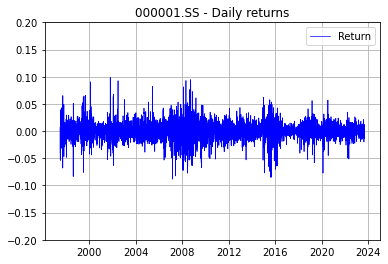

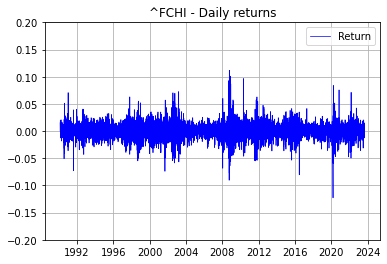

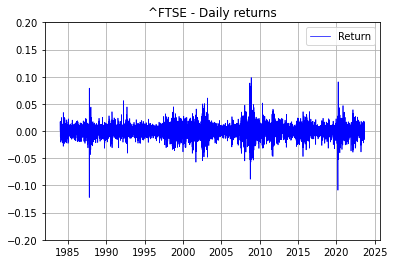

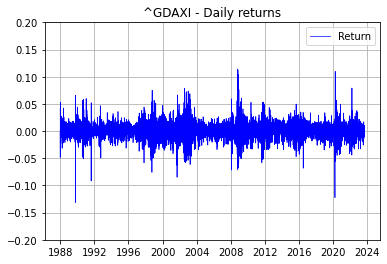

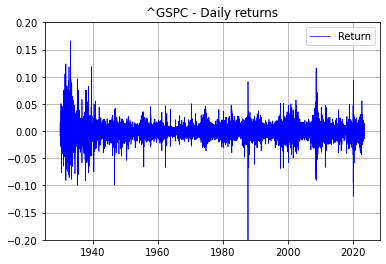

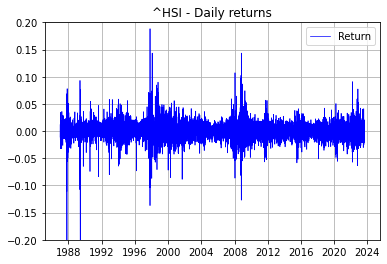

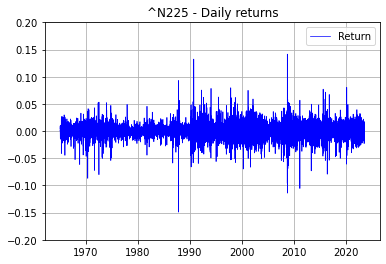

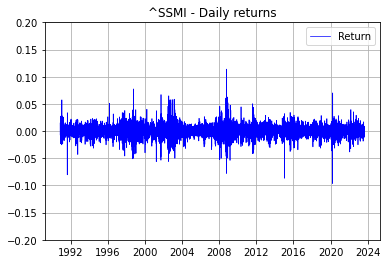

In [3]:
return_df = index_df['Adj Close'].pct_change()
for index_name in return_df: 
    plt.plot(return_df[index_name], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(index_name + ' - Daily returns')
    plt.show()

In [4]:
# Autocorrelation: daily return is not a strong predictor for the price change of the following day
for index_name in return_df:
    print(return_df[index_name].autocorr(lag=1))

0.010656509124401406
-0.010884652531489885
-0.0016711262069110079
-0.016289945112698365
-0.01737814342021477
-0.008046036822312568
-0.010419758350281484
0.02703440770157935


## Drawdown
def: total loss over consequtive days from the last maximum to the next minimum of the price

In [5]:
for index_name in index_df:
    print(index_df[index_name])

Date
1930-01-02            NaN
1930-01-03            NaN
1930-01-06            NaN
1930-01-07            NaN
1930-01-08            NaN
                 ...     
2023-08-24    3082.239990
2023-08-25    3064.070068
2023-08-28    3098.639893
2023-08-29    3135.889893
2023-08-30    3137.139893
Name: (Adj Close, 000001.SS), Length: 24020, dtype: float64
Date
1930-01-02            NaN
1930-01-03            NaN
1930-01-06            NaN
1930-01-07            NaN
1930-01-08            NaN
                 ...     
2023-08-24    7214.459961
2023-08-25    7229.600098
2023-08-28    7324.709961
2023-08-29    7373.430176
2023-08-30    7364.399902
Name: (Adj Close, ^FCHI), Length: 24020, dtype: float64
Date
1930-01-02            NaN
1930-01-03            NaN
1930-01-06            NaN
1930-01-07            NaN
1930-01-08            NaN
                 ...     
2023-08-24    7333.600098
2023-08-25    7338.600098
2023-08-28            NaN
2023-08-29    7465.000000
2023-08-30    7473.700195
Name: (Adj 

In [17]:
# Testing
sp500 = index_df[("Adj Close", "^GSPC")]
index_change = sp500.diff()
drawdowns = []
drawdown_start = None
dd = 0
for date, price in index_df[("Adj Close", "^GSPC")].items():
    if drawdown_start is None and index_change[date] < 0:
        drawdown_start = date
        dd += index_change[date]
    elif drawdown_start is not None and index_change[date] <= 0:
        dd += index_change[date]
    elif drawdown_start is not None and index_change[date] > 0:
        drawdown_end = date
        duration = (drawdown_end - drawdown_start).days
        drawdown = dd / index_df[("Adj Close", "^GSPC")][drawdown_start]
        drawdowns.append((drawdown_start, drawdown_end, duration, drawdown))
        drawdown_start = None
        dd = 0
# Convert drawdowns list to DataFrame
drawdowns_df = pd.DataFrame(drawdowns, columns=['drawdown_start', 'drawdown_end', 'duration', 'drawdown'])
drawdowns_df = drawdowns_df.sort_values(by='drawdown')
drawdowns_df

,drawdown_start,drawdown_end,duration,drawdown
3204,1987-10-14,1987-10-20,6,-0.293811
152,1932-03-31,1932-04-14,14,-0.240766
4500,2008-10-01,2008-10-13,12,-0.230083
233,1933-07-19,1933-07-24,5,-0.219828
180,1932-09-08,1932-09-15,7,-0.218506
...,...,...,...,...
3644,1995-02-01,1995-02-02,1,-0.000043
4896,2015-02-11,2015-02-12,1,-0.000029
3465,1992-02-11,1992-02-12,1,-0.000024
5324,2021-11-15,2021-11-16,1,-0.000011


In [33]:
# M1: Consecutive dates, change 1week as unit?

drawdowns_dict = {}
drawdowns_f = []
for index_name in index_df['Adj Close']:
    index_change = index_df['Adj Close'][index_name].diff()
    drawdowns = []
    drawdown_start = None
    dd = 0
    for date, price in index_df['Adj Close'][index_name].items():
        if drawdown_start is None and index_change[date] < 0:
            drawdown_start = date
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] <= 0:
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] > 0:
            drawdown_end = date
            duration = (drawdown_end - drawdown_start).days
            drawdown = dd / index_df['Adj Close'][index_name][drawdown_start]
            drawdowns.append((drawdown_start, drawdown_end, duration, drawdown))
            drawdown_start = None
            dd = 0

    # Convert drawdowns list to DataFrame
    drawdowns_df = pd.DataFrame(drawdowns, columns=['drawdown_start', 'drawdown_end', 'duration', 'drawdown'])
    drawdowns_df = drawdowns_df.sort_values(by='drawdown')
    drawdowns_dict[index_name] = drawdowns_df

drawdowns_dict

{'000001.SS':      drawdown_start drawdown_end  duration  drawdown
 1060     2015-08-20   2015-08-27         7 -0.236559
 1052     2015-07-01   2015-07-06         5 -0.145622
 1051     2015-06-25   2015-06-30         5 -0.140714
 12       1997-09-22   1997-09-24         2 -0.129130
 658      2008-10-21   2008-10-28         7 -0.127981
 ...             ...          ...       ...       ...
 911      2012-12-19   2012-12-20         1 -0.000104
 1132     2016-08-29   2016-08-30         1 -0.000092
 1140     2016-10-20   2016-10-21         1 -0.000085
 382      2004-02-19   2004-02-20         1 -0.000047
 798      2011-02-25   2011-02-28         3 -0.000013
 
 [1562 rows x 4 columns],
 '^FCHI':      drawdown_start drawdown_end  duration  drawdown
 1898     2020-03-05   2020-03-13         8 -0.264989
 748      2002-09-12   2002-09-25        13 -0.201802
 1340     2011-07-25   2011-08-09        15 -0.188176
 1166     2008-10-08   2008-10-13         5 -0.158921
 734      2002-07-19   2002-07-2

In [9]:
# M2: rolling max, inaccurate
drawdowns = []
dd_start = None
mdd = 0
for date, drawdown in dd.items():
    if dd_start is None and drawdown < 0:
        dd_start = date
        mdd = drawdown
    elif dd_start is not None and drawdown <= mdd:
        mdd = drawdown
    elif dd_start is not None and drawdown > mdd:
        dd_end = date
        duration = (dd_end - dd_start).days
        drawdowns.append((dd_start, dd_end, duration, mdd))
        dd_start = None
        mdd = 0
# Convert drawdowns list to DataFrame
drawdowns_df = pd.DataFrame(drawdowns, columns=['drawdown_start', 'drawdown_end', 'duration', 'drawdown'])
drawdowns_df = drawdowns_df.sort_values(by='drawdown')
drawdowns_df
        

,drawdown_start,drawdown_end,duration,drawdown


In [79]:
#M3:
dd_df = {}
for index_name in index_df:
    pmin_pmax = (index_df[index_name].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    dd = (np.array(index_df[index_name][pmin.index]) - np.array(index_df[index_name][pmax.index])) / np.array(index_df[index_name][pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, 'duration': dur}    
    df_d = df_d.sort_values(by='drawdown')
    dd_df[index_name[1]] = df_d

In [78]:
dd_df

{'000001.SS':             drawdown    d_start      d_end  duration
 Date                                                
 2022-04-27 -0.999764 2022-04-27 2022-04-28         1
 2003-09-12 -0.999523 2003-09-12 2003-09-22         6
 2016-01-05 -0.735481 2016-01-05 2016-01-07         2
 2003-04-16 -0.712821 2003-04-16 2003-04-22         4
 2004-05-27 -0.704918 2004-05-27 2004-05-31         2
 ...              ...        ...        ...       ...
 2021-07-08 -0.002850 2021-07-08 2021-07-09         1
 2019-07-18 -0.002751 2019-07-18 2019-07-19         1
 2022-02-22 -0.002145 2022-02-22 2022-02-23         1
 2017-12-25 -0.000702 2017-12-25 2017-12-26         1
 2019-12-13 -0.000472 2019-12-13 2019-12-16         1
 
 [1429 rows x 4 columns],
 '^FCHI':             drawdown    d_start      d_end  duration
 Date                                                
 2021-03-15 -0.989758 2021-03-15 2021-03-17         2
 2014-12-19 -0.933398 2014-12-19 2014-12-24         3
 2021-12-17 -0.919491 2021-12-17

## Identify Crashes
- 99.5% percentile of drawdowns

In [34]:
# Crash Identification
crashes = {}
for index, dd in drawdowns_dict.items():
    crash_threshold = dd['drawdown'].iloc[round(dd.shape[0] * 0.005)]
    crash_df = dd[dd['drawdown'] < crash_threshold]
    crash_df.columns = ['drawdown', 'crash_start', 'crash_end', 'duration']
    crashes[index] = crash_df
crashes


{'000001.SS':        drawdown crash_start  crash_end  duration
 1060 2015-08-20  2015-08-27          7 -0.236559
 1052 2015-07-01  2015-07-06          5 -0.145622
 1051 2015-06-25  2015-06-30          5 -0.140714
 12   1997-09-22  1997-09-24          2 -0.129130
 658  2008-10-21  2008-10-28          7 -0.127981
 612  2008-01-21  2008-01-23          2 -0.126314
 621  2008-03-12  2008-03-19          7 -0.122105
 227  2001-07-23  2001-08-01          9 -0.119551,
 '^FCHI':        drawdown crash_start  crash_end  duration
 1898 2020-03-05  2020-03-13          8 -0.264989
 748  2002-09-12  2002-09-25         13 -0.201802
 1340 2011-07-25  2011-08-09         15 -0.188176
 1166 2008-10-08  2008-10-13          5 -0.158921
 734  2002-07-19  2002-07-25          6 -0.147417
 23   1990-08-10  1990-08-22         12 -0.137795
 682  2001-09-05  2001-09-12          7 -0.134359
 775  2003-03-04  2003-03-13          9 -0.134217
 1167 2008-10-15  2008-10-17          2 -0.132360
 1115 2008-01-15  2008-01-2

In [41]:
# Crashes Count
crash_count = 0
for index, crashes_df in crashes.items():
    crash_count += len(crashes_df)
crash_count

107